In [222]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import collections
import pandas as pd
import random
import plotly.offline as offline
import plotly.plotly as py
import plotly.graph_objs as go


%matplotlib inline
offline.init_notebook_mode(connected=True)

In [2]:
Exp_Timeline = pd.read_csv("/home/tao/jupyter3/Tel_Data/Exp_TimeLine.csv")
ECG_meta = pd.read_csv("/home/tao/jupyter3/Tel_Data/ECG_MetaInfor.csv")
display(Exp_Timeline)
display(ECG_meta.head())

,Start,End,Label,Class
0,21-MAR-17,24-MAR-17,E06_Baseline_Time,1
1,12-APR-17,15-APR-17,E06_Peak_Time,0
2,27-JUL-16,30-JUL-16,E30_Baseline_Time,1
3,19-AUG-16,22-AUG-16,E30_Peak_Time,0
4,10-JAN-17,13-JAN-17,E07B_Baseline_Time,1
5,27-JAN-17,30-JAN-17,E07B_Peak_Time,0


,sub,desc1,tel,dtype,desc2,id,Exp,Species
0,196,Telemetry Collection from ECG Sensor for RIh16...,Telemetry,TEL_ECG,Telemetry Collection from ECG Sensor,1912,E06,RIh16
1,201,Telemetry Collection from ECG Sensor for RTe16...,Telemetry,TEL_ECG,Telemetry Collection from ECG Sensor,1915,E06,RTe16
2,206,Telemetry Collection from ECG Sensor for RCl15...,Telemetry,TEL_ECG,Telemetry Collection from ECG Sensor,1916,E06,RCl15
3,211,Telemetry Collection from ECG Sensor for RUf16...,Telemetry,TEL_ECG,Telemetry Collection from ECG Sensor,1918,E06,RUf16
4,220,Telemetry Collection from ECG Sensor for 12C13...,Telemetry,TEL_ECG,Telemetry Collection from ECG Sensor,1401,E07B,12C136


In [4]:
X_H0 = list()
Y_H0 = list()
### Baseline
for i in range(0, 13):
    dd = "/mnt/data0/tao/ECG/" + ECG_meta.Exp[i] + "/Baseline/" + ECG_meta.Species[i]
    file_hour = [x for x in os.listdir(dd) if '_H0_' in x]
    for item in file_hour:
        ff = dd + "/" + item
        data = pd.read_csv(ff)
        X_H0.append(list(data.VALUE.values))
        Y_H0.append(0)
### Peak
for i in range(0, 13):
    dd = "/mnt/data0/tao/ECG/" + ECG_meta.Exp[i] + "/Peak/" + ECG_meta.Species[i]
    file_hour = [x for x in os.listdir(dd) if '_H0_' in x]
    for item in file_hour:
        ff = dd + "/" + item
        data = pd.read_csv(ff)
        X_H0.append(list(data.VALUE.values))
        Y_H0.append(1)

X_H0 = np.asarray(X_H0)
Y_H0 = np.asarray(Y_H0)
print(np.shape(X_H0))
print(np.shape(Y_H0))

(9345, 10001)
(9345,)


In [5]:
print('Baseline # :', len([x for x in Y_H0 if x == 0]))
print('Peak # :', len([x for x in Y_H0 if x == 1]))

Baseline # : 3692
Peak # : 5653


In [6]:
x_train, x_test, y_train, y_test = train_test_split(X_H0, Y_H0, test_size=0.1)

print("x_train : ", len(x_train))
print("x_test  : ", len(x_test))
print("y_train : ", collections.Counter(y_train))
print("y_test  : ", collections.Counter(y_test))

x_train :  8410
x_test  :  935
y_train :  Counter({1: 5063, 0: 3347})
y_test  :  Counter({1: 590, 0: 345})


In [7]:
print(np.shape(x_train[0]))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

(10001,)
(8410,)
(935, 10001)
(935,)


In [66]:
# Normalize
x_train = normalize(x_train, axis=0, norm='max')
x_test = normalize(x_test, axis=0, norm='max')

# Specify that all features have real-value data
feature_columns = [tf.feature_column.numeric_column("ecg", shape=np.shape(x_train[0]))]

# Build Classifier
estimator = tf.estimator.LinearClassifier(
    feature_columns=feature_columns,
    n_classes=2,
    optimizer=tf.train.FtrlOptimizer(
      learning_rate=0.1,
      l1_regularization_strength=0.001
    )
)

# Train model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ecg": np.array(x_train)},
    y=np.array(y_train),
    batch_size=100,
    num_epochs=1000,
    shuffle=True
)

estimator.train(input_fn=train_input_fn, steps=10000)

# Evaluate accuracy
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ecg": np.array(x_test)},
    y=np.array(y_test),
    batch_size=10,
    num_epochs=1,
    shuffle=False
)

accuracy_score = estimator.evaluate(input_fn=test_input_fn)["accuracy"]

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpjk7j_5e6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f260e2e6898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpjk7j_5e6/model.ckpt.
INFO:ten

INFO:tensorflow:loss = 52.27883, step = 7301 (0.647 sec)
INFO:tensorflow:global_step/sec: 154.494
INFO:tensorflow:loss = 59.902428, step = 7401 (0.647 sec)
INFO:tensorflow:global_step/sec: 153.044
INFO:tensorflow:loss = 55.02206, step = 7501 (0.653 sec)
INFO:tensorflow:global_step/sec: 151.858
INFO:tensorflow:loss = 57.968773, step = 7601 (0.659 sec)
INFO:tensorflow:global_step/sec: 149.516
INFO:tensorflow:loss = 59.08509, step = 7701 (0.669 sec)
INFO:tensorflow:global_step/sec: 152.668
INFO:tensorflow:loss = 50.12422, step = 7801 (0.655 sec)
INFO:tensorflow:global_step/sec: 130.002
INFO:tensorflow:loss = 61.96545, step = 7901 (0.770 sec)
INFO:tensorflow:global_step/sec: 143.659
INFO:tensorflow:loss = 60.32515, step = 8001 (0.697 sec)
INFO:tensorflow:global_step/sec: 153.747
INFO:tensorflow:loss = 57.267853, step = 8101 (0.650 sec)
INFO:tensorflow:global_step/sec: 155.56
INFO:tensorflow:loss = 60.599228, step = 8201 (0.644 sec)
INFO:tensorflow:global_step/sec: 156.143
INFO:tensorflow:l

In [67]:
# Predict
pred_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"ecg": np.array(x_test)},
    shuffle=False
)

predictions = estimator.predict(input_fn=pred_input_fn)

In [69]:
# Plot matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        #cm[i, j] = 0 if np.isnan(cm[i, j]) else cm[i, j]
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpjk7j_5e6/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Test Accuracy: 51.764709%

Normalized confusion matrix


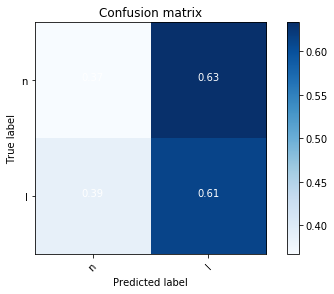

In [70]:
pred = list()
for p in predictions:
    pred.append(p["class_ids"][0])
    
cm = confusion_matrix(y_test, pred)

print("\nTest Accuracy: {0:f}%\n".format(accuracy_score*100))
plot_confusion_matrix(cm, classes, normalize=True)

### Keras Training

1. Define the sequential model that is used to train.

2. Set of neural network layers

In [8]:
### Separate the dataset into training and testing.
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import backend as K

x_train, x_test, y_train, y_test = train_test_split(X_H0, Y_H0, test_size=0.1)
print("x_train : ", len(x_train))
print("x_test  : ", len(x_test))
print("y_train : ", collections.Counter(y_train))
print("y_test  : ", collections.Counter(y_test))
## Print train & test
print(np.shape(x_train[0]))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))
# Normalize
# x_train = normalize(x_train, axis=0, norm='max')
# x_test = normalize(x_test, axis=0, norm='max')
y_train = keras.utils.to_categorical(y_train, num_classes=2)
y_test = keras.utils.to_categorical(y_test, num_classes=2)

Using TensorFlow backend.


x_train :  8410
x_test  :  935
y_train :  Counter({1: 5093, 0: 3317})
y_test  :  Counter({1: 560, 0: 375})
(10001,)
(8410,)
(935, 10001)
(935,)


In [3]:
### Separate the dataset into training and testing.
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import backend as K

Using TensorFlow backend.


In [4]:
### Define F1 metric
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [150]:
### Keras Sequential Models
model = Sequential()
model.add(Dense(256, input_dim=10001, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(2, activation='sigmoid'))
model.summary()

### Compilation
# For a binary classification problem
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy', f1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_156 (Dense)            (None, 256)               2560512   
_________________________________________________________________
dropout_126 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_157 (Dense)            (None, 128)               32896     
_________________________________________________________________
dropout_127 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_158 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_128 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_159 (Dense)            (None, 32)                2080      
__________

In [230]:
## Run the model
#history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_test, y_test))
# score = model.evaluate(x_test, y_test, batch_size=128)

In [229]:
# Plot learning curve
#plt.figure(figsize=(15,15))
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.legend(['loss','val_loss'], loc='upper right',prop={'size': 15});
#plt.title('Learning curve for the training of Dense Layers', fontsize=15)
#plt.show()
#print('Best test F1 score: ' + max(history.history['f1']).astype(str))

## Second Train

In [165]:
## Run the model
results = list()
sample_size = list()
fprs = list()
tprs = list()
aucs = list()
for k in range(0, 24):
    fx_n = '/mnt/data0/tao/ECG/hdf5/ECG_H' + str(k) + '_Dataset.h5'
    fy_n = '/mnt/data0/tao/ECG/hdf5/ECG_H' + str(k) + '_Label.h5'
    x_n = 'ECG_H' + str(k)    
    with h5py.File(fx_n, 'r') as hf:
        X_H = hf["x_n"][:]
    with h5py.File(fy_n, 'r') as hf:
        Y_H = hf["x_n"][:]
    x_train, x_test, y_train, y_test = train_test_split(X_H, Y_H, test_size=0.1)
    ## Print train & test
    print(k)
    print(np.shape(x_train[0]))
    print(np.shape(y_train))
    print(np.shape(x_test))
    print(np.shape(y_test))
    model = Sequential()
    model.add(Dense(128, input_dim=10001, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))
### Compilation
# For a binary classification problem
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1])
    y_train = keras.utils.to_categorical(y_train, num_classes=2)
    y_test = keras.utils.to_categorical(y_test, num_classes=2)
    history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_test, y_test))
    preds = model.predict(x_test, verbose=1)
    gt = np.argmax(y_test, axis=1)
    binary_gt = gt == 0
    binary_probs = preds[..., 0]
    fpr, tpr, _ = skm.roc_curve(binary_gt.ravel(), binary_probs.ravel())
    auc = skm.auc(fpr, tpr)
    results.append([k, max(history.history['acc']).astype(str), max(history.history['f1']).astype(str), 
                    max(history.history['val_acc']).astype(str), max(history.history['val_f1']).astype(str)])
    sample_size.append([len(x_train), len(x_test)])
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc)

0
(10001,)
(8410,)
(935, 10001)
(935,)
Train on 8410 samples, validate on 935 samples
Epoch 1/20
8410/8410 [==============================] - 22s 3ms/step - loss: 0.7410 - acc: 0.5387 - f1: 0.5570 - val_loss: 0.6790 - val_acc: 0.5995 - val_f1: 0.6001
Epoch 2/20
8410/8410 [==============================] - 1s 87us/step - loss: 0.7158 - acc: 0.5644 - f1: 0.5723 - val_loss: 0.6812 - val_acc: 0.5968 - val_f1: 0.5968
Epoch 3/20
8410/8410 [==============================] - 1s 87us/step - loss: 0.6984 - acc: 0.5810 - f1: 0.5840 - val_loss: 0.6786 - val_acc: 0.5979 - val_f1: 0.5979
Epoch 4/20
8410/8410 [==============================] - 1s 86us/step - loss: 0.6879 - acc: 0.5927 - f1: 0.5917 - val_loss: 0.6762 - val_acc: 0.5979 - val_f1: 0.5979
Epoch 5/20
8410/8410 [==============================] - 1s 89us/step - loss: 0.6855 - acc: 0.5944 - f1: 0.5953 - val_loss: 0.6760 - val_acc: 0.5979 - val_f1: 0.5979
Epoch 6/20
8410/8410 [==============================] - 1s 100us/step - loss: 0.6786 - ac

10557/10557 [==============================] - 1s 84us/step - loss: 0.5852 - acc: 0.7069 - f1: 0.7090 - val_loss: 0.6075 - val_acc: 0.6895 - val_f1: 0.6923
Epoch 16/20
10557/10557 [==============================] - 1s 85us/step - loss: 0.5746 - acc: 0.7126 - f1: 0.7139 - val_loss: 0.6059 - val_acc: 0.6921 - val_f1: 0.6936
Epoch 17/20
10557/10557 [==============================] - 1s 89us/step - loss: 0.5554 - acc: 0.7298 - f1: 0.7306 - val_loss: 0.5943 - val_acc: 0.6985 - val_f1: 0.7000
Epoch 18/20
10557/10557 [==============================] - 1s 86us/step - loss: 0.5432 - acc: 0.7405 - f1: 0.7411 - val_loss: 0.5907 - val_acc: 0.6925 - val_f1: 0.6941
Epoch 19/20
10557/10557 [==============================] - 1s 105us/step - loss: 0.5323 - acc: 0.7500 - f1: 0.7503 - val_loss: 0.5874 - val_acc: 0.7061 - val_f1: 0.7072
Epoch 20/20
1174/1174 [==============================] - 9s 7ms/step
5
(10001,)
(11257,)
(1251, 10001)
(1251,)
Train on 11257 samples, validate on 1251 samples
Epoch 1/20


10529/10529 [==============================] - 1s 105us/step - loss: 0.6695 - acc: 0.6115 - f1: 0.6133 - val_loss: 0.6576 - val_acc: 0.6333 - val_f1: 0.6333
Epoch 9/20
10529/10529 [==============================] - 1s 86us/step - loss: 0.6686 - acc: 0.6130 - f1: 0.6140 - val_loss: 0.6570 - val_acc: 0.6333 - val_f1: 0.6333
Epoch 10/20
10529/10529 [==============================] - 1s 80us/step - loss: 0.6672 - acc: 0.6147 - f1: 0.6160 - val_loss: 0.6571 - val_acc: 0.6333 - val_f1: 0.6333
Epoch 11/20
10529/10529 [==============================] - 1s 81us/step - loss: 0.6668 - acc: 0.6134 - f1: 0.6152 - val_loss: 0.6562 - val_acc: 0.6333 - val_f1: 0.6333
Epoch 12/20
10529/10529 [==============================] - 1s 79us/step - loss: 0.6652 - acc: 0.6161 - f1: 0.6173 - val_loss: 0.6560 - val_acc: 0.6342 - val_f1: 0.6342
Epoch 13/20
10529/10529 [==============================] - 1s 80us/step - loss: 0.6644 - acc: 0.6146 - f1: 0.6157 - val_loss: 0.6553 - val_acc: 0.6342 - val_f1: 0.6342
Epoc

Epoch 2/20
8289/8289 [==============================] - 1s 82us/step - loss: 0.7344 - acc: 0.6115 - f1: 0.6021 - val_loss: 0.7402 - val_acc: 0.6336 - val_f1: 0.6334
Epoch 3/20
8289/8289 [==============================] - 1s 81us/step - loss: 0.7138 - acc: 0.6358 - f1: 0.6310 - val_loss: 0.7296 - val_acc: 0.6341 - val_f1: 0.6341
Epoch 4/20
8289/8289 [==============================] - 1s 81us/step - loss: 0.6967 - acc: 0.6451 - f1: 0.6413 - val_loss: 0.7289 - val_acc: 0.6363 - val_f1: 0.6363
Epoch 5/20
8289/8289 [==============================] - 1s 82us/step - loss: 0.6998 - acc: 0.6494 - f1: 0.6467 - val_loss: 0.7102 - val_acc: 0.6341 - val_f1: 0.6341
Epoch 6/20
8289/8289 [==============================] - 1s 80us/step - loss: 0.6852 - acc: 0.6549 - f1: 0.6540 - val_loss: 0.7076 - val_acc: 0.6330 - val_f1: 0.6330
Epoch 7/20
8289/8289 [==============================] - 1s 80us/step - loss: 0.6755 - acc: 0.6530 - f1: 0.6515 - val_loss: 0.7046 - val_acc: 0.6352 - val_f1: 0.6352
Epoch 8/20

Epoch 10/20
8345/8345 [==============================] - 1s 106us/step - loss: 0.6725 - acc: 0.5769 - f1: 0.5770 - val_loss: 0.6888 - val_acc: 0.5296 - val_f1: 0.5243
Epoch 11/20
8345/8345 [==============================] - 1s 83us/step - loss: 0.6700 - acc: 0.5890 - f1: 0.5896 - val_loss: 0.6869 - val_acc: 0.5393 - val_f1: 0.5352
Epoch 12/20
8345/8345 [==============================] - 1s 82us/step - loss: 0.6639 - acc: 0.5892 - f1: 0.5902 - val_loss: 0.6781 - val_acc: 0.5550 - val_f1: 0.5514
Epoch 13/20
8345/8345 [==============================] - 1s 83us/step - loss: 0.6611 - acc: 0.6014 - f1: 0.6022 - val_loss: 0.6793 - val_acc: 0.5555 - val_f1: 0.5543
Epoch 14/20
8345/8345 [==============================] - 1s 82us/step - loss: 0.6521 - acc: 0.6143 - f1: 0.6151 - val_loss: 0.6742 - val_acc: 0.5636 - val_f1: 0.5623
Epoch 15/20
8345/8345 [==============================] - 1s 84us/step - loss: 0.6460 - acc: 0.6234 - f1: 0.6238 - val_loss: 0.6710 - val_acc: 0.5690 - val_f1: 0.5681
Epo

Epoch 18/20
7490/7490 [==============================] - 1s 81us/step - loss: 0.6904 - acc: 0.5466 - f1: 0.5521 - val_loss: 0.6912 - val_acc: 0.5252 - val_f1: 0.5256
Epoch 19/20
7490/7490 [==============================] - 1s 82us/step - loss: 0.6894 - acc: 0.5435 - f1: 0.5503 - val_loss: 0.6916 - val_acc: 0.5210 - val_f1: 0.5216
Epoch 20/20
833/833 [==============================] - 10s 12ms/step
19
(10001,)
(9271,)
(1031, 10001)
(1031,)
Train on 9271 samples, validate on 1031 samples
Epoch 1/20
9271/9271 [==============================] - 26s 3ms/step - loss: 0.7652 - acc: 0.5160 - f1: 0.4890 - val_loss: 0.6824 - val_acc: 0.6086 - val_f1: 0.6144
Epoch 2/20
9271/9271 [==============================] - 1s 115us/step - loss: 0.7154 - acc: 0.5590 - f1: 0.5478 - val_loss: 0.6780 - val_acc: 0.6086 - val_f1: 0.6092
Epoch 3/20
9271/9271 [==============================] - 1s 88us/step - loss: 0.6918 - acc: 0.5809 - f1: 0.5724 - val_loss: 0.6732 - val_acc: 0.6120 - val_f1: 0.6119
Epoch 4/20
92

Epoch 5/20
7812/7812 [==============================] - 1s 85us/step - loss: 0.6867 - acc: 0.5605 - f1: 0.5553 - val_loss: 0.6720 - val_acc: 0.5829 - val_f1: 0.5784
Epoch 6/20
7812/7812 [==============================] - 1s 82us/step - loss: 0.6674 - acc: 0.5871 - f1: 0.5829 - val_loss: 0.6505 - val_acc: 0.6123 - val_f1: 0.6123
Epoch 7/20
7812/7812 [==============================] - 1s 82us/step - loss: 0.6482 - acc: 0.6237 - f1: 0.6247 - val_loss: 0.6261 - val_acc: 0.6429 - val_f1: 0.6432
Epoch 8/20
7812/7812 [==============================] - 1s 82us/step - loss: 0.6406 - acc: 0.6381 - f1: 0.6390 - val_loss: 0.6120 - val_acc: 0.6607 - val_f1: 0.6595
Epoch 9/20
7812/7812 [==============================] - 1s 82us/step - loss: 0.6133 - acc: 0.6739 - f1: 0.6738 - val_loss: 0.5875 - val_acc: 0.6901 - val_f1: 0.6905
Epoch 10/20
7812/7812 [==============================] - 1s 82us/step - loss: 0.5799 - acc: 0.7010 - f1: 0.7010 - val_loss: 0.5621 - val_acc: 0.6947 - val_f1: 0.6951
Epoch 11/

In [168]:
results = pd.DataFrame(results)
results.columns = ['Hour', 'Training_Acc', 'Training_F1', 'Testing_Acc', 'Testing_F1']
sample_size = pd.DataFrame(sample_size)
sample_size.columns = ['Training_Sample', 'Testing_Sample']
Summary_T2 = pd.concat([results, sample_size], axis=1)
Summary_T2

,Hour,Training_Acc,Training_F1,Testing_Acc,Testing_F1,Training_Sample,Testing_Sample
0,0,0.6237812130544755,0.6262034862135026,0.616577541254421,0.6147016297687183,8410,935
1,1,0.715049571112932,0.7159719670736485,0.6903807615230461,0.694121945716575,8977,998
2,2,0.657981562278966,0.6574413338140167,0.5921397397091295,0.5917629279424009,10305,1145
3,3,0.7537721613360908,0.7526012328560512,0.6738761656864707,0.6731303084998741,10604,1179
4,4,0.7606801175423008,0.760896008032972,0.7061328795537023,0.7071572448772709,10557,1174
5,5,0.6550590745178773,0.6547077368480587,0.6558752980925958,0.654651168915484,11257,1251
6,6,0.7238263171334505,0.7234123975189609,0.6243805760080207,0.6247544152767381,9074,1009
7,7,0.5518204025353084,0.547626847158383,0.5428870285405275,0.5433048179458874,8597,956
8,8,0.5476323120219905,0.5463962823567616,0.5430242272347535,0.5370567169105798,10770,1197
9,9,0.6417988412615037,0.6418362098186713,0.6384615383596501,0.6384614787550054,10529,1170


In [200]:
fprs = np.asarray(fprs)
tprs = np.asarray(tprs)

In [208]:
np.savetxt("/mnt/data0/tao/ECG/results/ECG_Classification_Hourly_fprs.txt", fprs, fmt='%s')
np.savetxt("/mnt/data0/tao/ECG/results/ECG_Classification_Hourly_tprs.txt", tprs, fmt='%s')

In [212]:
dt = h5py.special_dtype(vlen=np.dtype('float64'))
with h5py.File("/mnt/data0/tao/ECG/results/ECG_Classification_Hourly_fprs.h5", 'w') as hf:
    hf.create_dataset("fprs", data=fprs, dtype=dt)
with h5py.File("/mnt/data0/tao/ECG/results/ECG_Classification_Hourly_tprs.h5", 'w') as hf:
    hf.create_dataset("tprs", data=tprs, dtype=dt)

In [217]:
Summary_T2['AUC'] = aucs
Summary_T2.to_csv('/mnt/data0/tao/ECG/results/Summarized_hourly_stats.csv', index=False)

In [218]:
Summary_T2

,Hour,Training_Acc,Training_F1,Testing_Acc,Testing_F1,Training_Sample,Testing_Sample,AUC
0,0,0.6237812130544755,0.6262034862135026,0.616577541254421,0.6147016297687183,8410,935,0.619762
1,1,0.715049571112932,0.7159719670736485,0.6903807615230461,0.694121945716575,8977,998,0.675822
2,2,0.657981562278966,0.6574413338140167,0.5921397397091295,0.5917629279424009,10305,1145,0.610477
3,3,0.7537721613360908,0.7526012328560512,0.6738761656864707,0.6731303084998741,10604,1179,0.691539
4,4,0.7606801175423008,0.760896008032972,0.7061328795537023,0.7071572448772709,10557,1174,0.762644
5,5,0.6550590745178773,0.6547077368480587,0.6558752980925958,0.654651168915484,11257,1251,0.687353
6,6,0.7238263171334505,0.7234123975189609,0.6243805760080207,0.6247544152767381,9074,1009,0.655783
7,7,0.5518204025353084,0.547626847158383,0.5428870285405275,0.5433048179458874,8597,956,0.523834
8,8,0.5476323120219905,0.5463962823567616,0.5430242272347535,0.5370567169105798,10770,1197,0.560332
9,9,0.6417988412615037,0.6418362098186713,0.6384615383596501,0.6384614787550054,10529,1170,0.608563


### First Train

In [7]:
### Train from Hour 0 to Hour 23
results = list()
sample_size = list()
for k in range(0, 24):
    print(k)
    X_H = list()
    Y_H = list()
### Baseline
    for i in range(0, 13):
        dd = "/mnt/data0/tao/ECG/" + ECG_meta.Exp[i] + "/Baseline/" + ECG_meta.Species[i]
        fname = '_H' + str(k) + '_'
        file_hour = [x for x in os.listdir(dd) if fname in x]
        for item in file_hour:
            ff = dd + "/" + item
            data = pd.read_csv(ff)
            X_H.append(list(data.VALUE.values))
            Y_H.append(0)
### Peak
    for i in range(0, 13):
        dd = "/mnt/data0/tao/ECG/" + ECG_meta.Exp[i] + "/Peak/" + ECG_meta.Species[i]
        fname = '_H' + str(k) + '_'
        file_hour = [x for x in os.listdir(dd) if fname in x]
        for item in file_hour:
            ff = dd + "/" + item
            data = pd.read_csv(ff)
            X_H.append(list(data.VALUE.values))
            Y_H.append(1)    
    X_H = np.asarray(X_H)
    Y_H = np.asarray(Y_H)
    print(np.shape(X_H))
    print(np.shape(Y_H))
    print('Baseline # :', len([x for x in Y_H if x == 0]))
    print('Peak # :', len([x for x in Y_H if x == 1]))
    x_train, x_test, y_train, y_test = train_test_split(X_H, Y_H, test_size=0.1)
    print("x_train : ", len(x_train))
    print("x_test  : ", len(x_test))
    print("y_train : ", collections.Counter(y_train))
    print("y_test  : ", collections.Counter(y_test))
    ## Print train & test
    print(np.shape(x_train[0]))
    print(np.shape(y_train))
    print(np.shape(x_test))
    print(np.shape(y_test))### Keras Sequential Models
    model = Sequential()
    model.add(Dense(128, input_dim=10001, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))
### Compilation
# For a binary classification problem
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1])
    y_train = keras.utils.to_categorical(y_train, num_classes=2)
    y_test = keras.utils.to_categorical(y_test, num_classes=2)
    history = model.fit(x_train, y_train, epochs=25, batch_size=128, validation_data=(x_test, y_test))
    results.append([k, max(history.history['acc']).astype(str), max(history.history['f1']).astype(str), 
                    max(history.history['val_acc']).astype(str), max(history.history['val_f1']).astype(str)])
    sample_size.append([len(x_train), len(x_test)])

0
(9345, 10001)
(9345,)
Baseline # : 3692
Peak # : 5653
x_train :  8410
x_test  :  935
y_train :  Counter({1: 5095, 0: 3315})
y_test  :  Counter({1: 558, 0: 377})
(10001,)
(8410,)
(935, 10001)
(935,)
Train on 8410 samples, validate on 935 samples
Epoch 1/25
8410/8410 [==============================] - 1s 144us/step - loss: 0.7374 - acc: 0.5461 - f1: 0.5609 - val_loss: 0.6827 - val_acc: 0.5952 - val_f1: 0.5958
Epoch 2/25
8410/8410 [==============================] - 1s 76us/step - loss: 0.7048 - acc: 0.5685 - f1: 0.5687 - val_loss: 0.6822 - val_acc: 0.5957 - val_f1: 0.5949
Epoch 3/25
8410/8410 [==============================] - 1s 73us/step - loss: 0.6967 - acc: 0.5883 - f1: 0.5828 - val_loss: 0.6802 - val_acc: 0.5968 - val_f1: 0.5968
Epoch 4/25
8410/8410 [==============================] - 1s 70us/step - loss: 0.6944 - acc: 0.5905 - f1: 0.5879 - val_loss: 0.6795 - val_acc: 0.5968 - val_f1: 0.5968
Epoch 5/25
8410/8410 [==============================] - 1s 73us/step - loss: 0.6866 - acc: 0

Epoch 18/25
10604/10604 [==============================] - 1s 67us/step - loss: 0.5522 - acc: 0.7112 - f1: 0.7093 - val_loss: 0.6131 - val_acc: 0.6438 - val_f1: 0.6426
Epoch 19/25
10604/10604 [==============================] - 1s 67us/step - loss: 0.5479 - acc: 0.7220 - f1: 0.7214 - val_loss: 0.6046 - val_acc: 0.6285 - val_f1: 0.6278
Epoch 20/25
10604/10604 [==============================] - 1s 68us/step - loss: 0.5316 - acc: 0.7406 - f1: 0.7406 - val_loss: 0.6114 - val_acc: 0.6323 - val_f1: 0.6321
Epoch 21/25
10604/10604 [==============================] - 1s 68us/step - loss: 0.5162 - acc: 0.7528 - f1: 0.7528 - val_loss: 0.6193 - val_acc: 0.6272 - val_f1: 0.6271
Epoch 22/25
10604/10604 [==============================] - 1s 67us/step - loss: 0.5091 - acc: 0.7509 - f1: 0.7513 - val_loss: 0.6249 - val_acc: 0.6412 - val_f1: 0.6415
Epoch 23/25
10604/10604 [==============================] - 1s 67us/step - loss: 0.4987 - acc: 0.7640 - f1: 0.7643 - val_loss: 0.6250 - val_acc: 0.6264 - val_f1:

Epoch 14/25
11257/11257 [==============================] - 1s 68us/step - loss: 0.6463 - acc: 0.5989 - f1: 0.6002 - val_loss: 0.6588 - val_acc: 0.5955 - val_f1: 0.5955
Epoch 15/25
11257/11257 [==============================] - 1s 67us/step - loss: 0.6345 - acc: 0.6020 - f1: 0.6034 - val_loss: 0.6524 - val_acc: 0.5951 - val_f1: 0.5953
Epoch 16/25
11257/11257 [==============================] - 1s 67us/step - loss: 0.6230 - acc: 0.6113 - f1: 0.6128 - val_loss: 0.6459 - val_acc: 0.6055 - val_f1: 0.6060
Epoch 17/25
11257/11257 [==============================] - 1s 67us/step - loss: 0.6062 - acc: 0.6253 - f1: 0.6270 - val_loss: 0.6431 - val_acc: 0.6363 - val_f1: 0.6342
Epoch 18/25
11257/11257 [==============================] - 1s 66us/step - loss: 0.5992 - acc: 0.6449 - f1: 0.6466 - val_loss: 0.6367 - val_acc: 0.6623 - val_f1: 0.6611
Epoch 19/25
11257/11257 [==============================] - 1s 66us/step - loss: 0.5857 - acc: 0.6838 - f1: 0.6833 - val_loss: 0.6324 - val_acc: 0.6443 - val_f1:

10529/10529 [==============================] - 1s 70us/step - loss: 0.6763 - acc: 0.6114 - f1: 0.6142 - val_loss: 0.6627 - val_acc: 0.6316 - val_f1: 0.6316
Epoch 7/25
10529/10529 [==============================] - 1s 69us/step - loss: 0.6707 - acc: 0.6157 - f1: 0.6175 - val_loss: 0.6611 - val_acc: 0.6316 - val_f1: 0.6316
Epoch 8/25
10529/10529 [==============================] - 1s 68us/step - loss: 0.6699 - acc: 0.6125 - f1: 0.6145 - val_loss: 0.6599 - val_acc: 0.6316 - val_f1: 0.6316
Epoch 9/25
10529/10529 [==============================] - 1s 68us/step - loss: 0.6700 - acc: 0.6119 - f1: 0.6146 - val_loss: 0.6590 - val_acc: 0.6316 - val_f1: 0.6316
Epoch 10/25
10529/10529 [==============================] - 1s 67us/step - loss: 0.6671 - acc: 0.6154 - f1: 0.6172 - val_loss: 0.6584 - val_acc: 0.6316 - val_f1: 0.6316
Epoch 11/25
10529/10529 [==============================] - 1s 68us/step - loss: 0.6656 - acc: 0.6161 - f1: 0.6179 - val_loss: 0.6573 - val_acc: 0.6316 - val_f1: 0.6316
Epoch 1

6523/6523 [==============================] - 0s 76us/step - loss: 0.5229 - acc: 0.7275 - f1: 0.7276 - val_loss: 0.5892 - val_acc: 0.7352 - val_f1: 0.7352
13
(8446, 10001)
(8446,)
Baseline # : 2740
Peak # : 5706
x_train :  7601
x_test  :  845
y_train :  Counter({1: 5125, 0: 2476})
y_test  :  Counter({1: 581, 0: 264})
(10001,)
(7601,)
(845, 10001)
(845,)
Train on 7601 samples, validate on 845 samples
Epoch 1/25
7601/7601 [==============================] - 2s 275us/step - loss: 0.7961 - acc: 0.5339 - f1: 0.5542 - val_loss: 0.6710 - val_acc: 0.6888 - val_f1: 0.6881
Epoch 2/25
7601/7601 [==============================] - 1s 68us/step - loss: 0.7095 - acc: 0.6169 - f1: 0.6238 - val_loss: 0.6566 - val_acc: 0.6882 - val_f1: 0.6880
Epoch 3/25
7601/7601 [==============================] - 1s 68us/step - loss: 0.6873 - acc: 0.6470 - f1: 0.6497 - val_loss: 0.6459 - val_acc: 0.6876 - val_f1: 0.6876
Epoch 4/25
7601/7601 [==============================] - 1s 68us/step - loss: 0.6693 - acc: 0.6602 - f1

8345/8345 [==============================] - 1s 68us/step - loss: 0.6084 - acc: 0.6835 - f1: 0.6834 - val_loss: 0.6507 - val_acc: 0.5975 - val_f1: 0.5973
Epoch 18/25
8345/8345 [==============================] - 1s 69us/step - loss: 0.5956 - acc: 0.6860 - f1: 0.6864 - val_loss: 0.6587 - val_acc: 0.5954 - val_f1: 0.5951
Epoch 19/25
8345/8345 [==============================] - 1s 69us/step - loss: 0.5817 - acc: 0.7074 - f1: 0.7074 - val_loss: 0.6592 - val_acc: 0.6008 - val_f1: 0.6001
Epoch 20/25
8345/8345 [==============================] - 1s 71us/step - loss: 0.5758 - acc: 0.7104 - f1: 0.7105 - val_loss: 0.6555 - val_acc: 0.5900 - val_f1: 0.5897
Epoch 21/25
8345/8345 [==============================] - 1s 71us/step - loss: 0.5622 - acc: 0.7298 - f1: 0.7298 - val_loss: 0.6625 - val_acc: 0.5943 - val_f1: 0.5936
Epoch 22/25
8345/8345 [==============================] - 1s 76us/step - loss: 0.5456 - acc: 0.7330 - f1: 0.7329 - val_loss: 0.6648 - val_acc: 0.6029 - val_f1: 0.6022
Epoch 23/25
8345

8858/8858 [==============================] - 1s 69us/step - loss: 0.6802 - acc: 0.5775 - f1: 0.5771 - val_loss: 0.6718 - val_acc: 0.6030 - val_f1: 0.6029
Epoch 10/25
8858/8858 [==============================] - 1s 69us/step - loss: 0.6760 - acc: 0.5864 - f1: 0.5868 - val_loss: 0.6645 - val_acc: 0.6122 - val_f1: 0.6130
Epoch 11/25
8858/8858 [==============================] - 1s 69us/step - loss: 0.6657 - acc: 0.6004 - f1: 0.6004 - val_loss: 0.6489 - val_acc: 0.6193 - val_f1: 0.6200
Epoch 12/25
8858/8858 [==============================] - 1s 71us/step - loss: 0.6575 - acc: 0.6141 - f1: 0.6137 - val_loss: 0.6402 - val_acc: 0.6431 - val_f1: 0.6433
Epoch 13/25
8858/8858 [==============================] - 1s 70us/step - loss: 0.6517 - acc: 0.6218 - f1: 0.6213 - val_loss: 0.6358 - val_acc: 0.6553 - val_f1: 0.6551
Epoch 14/25
8858/8858 [==============================] - 1s 69us/step - loss: 0.6354 - acc: 0.6421 - f1: 0.6408 - val_loss: 0.6241 - val_acc: 0.6518 - val_f1: 0.6510
Epoch 15/25
8858

In [24]:
results = pd.DataFrame(results)
results.columns = ['Hour', 'Training_Acc', 'Training_F1', 'Testing_Acc', 'Testing_F1']

In [22]:
sample_size = pd.DataFrame(sample_size)
sample_size.columns = ['Training_Sample', 'Testing_Sample']

In [25]:
# Summary_T = pd.concat([results, sample_size], axis=1)
Summary_T

,Hour,Training_Acc,Training_F1,Testing_Acc,Testing_F1,Training_Sample,Testing_Sample
0,0,0.6643876334716534,0.6373365035663745,0.5967914439458898,0.5967913855843365,8410,935
1,1,0.7550963573377728,0.754469499020185,0.6883767523125321,0.6848854310287981,8977,998
2,2,0.7344007764320707,0.7348777705404956,0.60742357984901,0.6629905008332698,10305,1145
3,3,0.7789513391847658,0.7791312528933637,0.6776929602115411,0.6776929012893923,10604,1179
4,4,0.7884342142936462,0.7875614224526313,0.7201873931202409,0.7192936870674055,10557,1174
5,5,0.7777827127667952,0.7773609263674345,0.6638689065913407,0.663453481037268,11257,1251
6,6,0.71275071658199,0.7125885554654813,0.6233894976208538,0.623389438016209,9074,1009
7,7,0.5243689659738091,0.5211813250114381,0.5407949790794979,0.545885609034215,8597,956
8,8,0.6660167130697847,0.6659312105223107,0.5622389315064987,0.5618690470406286,10770,1197
9,9,0.6802165448376908,0.6802107521368801,0.6717948719986484,0.671794811477009,10529,1170


In [20]:
Summary_T.to_csv("/home/tao/jupyter3/Tel_Data/Summarization_ECG_Classification.csv", index=False)

In [232]:
### Plot summary
trace1 = go.Scatter(
    name='10-CV Training',
    x=Summary_T2.Hour,
    y=Summary_T2.Training_Acc,
    mode='markers')
trace2 = go.Scatter(
    name='Testing',
    x=Summary_T2.Hour,
    y=Summary_T2.Testing_Acc,
    mode='markers',
    opacity=0.7)
trace3 = go.Scatter(
    name = 'Sample Size',
    x=Summary_T2.Hour,
    y=Summary_T2.Training_Sample,
    yaxis='y2',
    mode='markers')
data = [trace1, trace2]
layout = go.Layout(
    yaxis=dict(title='Accuracy', range=[0,0.95]),
    xaxis=dict(title='Time'),
    yaxis2=dict(title='Number of samples',
               overlaying='y',
               side='right',
               range=[5000,12000]),
    title='Hourly Classification Results',
    showlegend = True)
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, show_link=False)

In [228]:
import sklearn.metrics as skm

lw = 2
trace1 = go.Scatter(x=fprs[23], y=tprs[23], 
                    mode='lines', 
                    line=dict(color='darkorange', width=lw),
                    name='H23 AUC(area = %0.2f)' % aucs[23])
trace2 = go.Scatter(x=[0, 1], y=[0, 1], 
                    mode='lines', 
                    line=dict(color='navy', width=lw, dash='dash'),
                    showlegend=False)
trace3 = go.Scatter(x=fprs[21], y=tprs[21], 
                    mode='lines', 
                    line=dict(color='cyan', width=lw),
                    name='H21 AUC(area = %0.2f)' % aucs[21])
trace4 = go.Scatter(x=fprs[18], y=tprs[18], 
                    mode='lines', 
                    line=dict(color='green', width=lw),
                    name='H18 AUC(area = %0.2f)' % aucs[18])
trace5 = go.Scatter(x=fprs[8], y=tprs[8], 
                    mode='lines', 
                    line=dict(color='indigo', width=lw),
                    name='H8 AUC(area = %0.2f)' % aucs[8])

layout = go.Layout(title='Hourly ROC Comparisons',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='Sensitivity'))
fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5], layout=layout)
offline.iplot(fig, show_link=False)

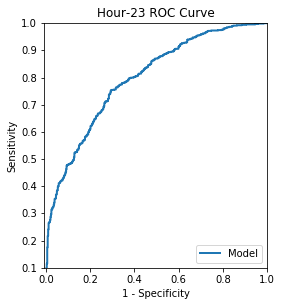

In [141]:
f, ax = plt.subplots(figsize=(4,4.5))
ax.plot(fpr, tpr, lw=2, label="Model")
ax.set_xlim(-0.008, 1.0)
ax.set_ylim(0.1, 1.0)
ax.set_title("Hour-23 ROC Curve")
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')
ax.legend(loc=4)

### Save the training files into hdf5 format

In [27]:
import h5py

In [39]:
for k in range(0, 24):
    print(k)
    X_H = list()
    Y_H = list()
### Baseline
    for i in range(0, 13):
        dd = "/mnt/data0/tao/ECG/" + ECG_meta.Exp[i] + "/Baseline/" + ECG_meta.Species[i]
        fname = '_H' + str(k) + '_'
        file_hour = [x for x in os.listdir(dd) if fname in x]
        for item in file_hour:
            ff = dd + "/" + item
            data = pd.read_csv(ff)
            X_H.append(list(data.VALUE.values))
            Y_H.append(0)
### Peak
    for i in range(0, 13):
        dd = "/mnt/data0/tao/ECG/" + ECG_meta.Exp[i] + "/Peak/" + ECG_meta.Species[i]
        fname = '_H' + str(k) + '_'
        file_hour = [x for x in os.listdir(dd) if fname in x]
        for item in file_hour:
            ff = dd + "/" + item
            data = pd.read_csv(ff)
            X_H.append(list(data.VALUE.values))
            Y_H.append(1)    
    X_H = np.asarray(X_H)
    Y_H = np.asarray(Y_H)
    fx_n = '/mnt/data0/tao/ECG/hdf5/ECG_H' + str(k) + '_Dataset.h5'
    fy_n = '/mnt/data0/tao/ECG/hdf5/ECG_H' + str(k) + '_Label.h5'
    x_n = 'ECG_H' + str(k)
    with h5py.File(fx_n, 'w') as hf:
        hf.create_dataset("x_n", data=X_H)
    with h5py.File(fy_n, 'w') as hf:
        hf.create_dataset("x_n", data=Y_H)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
